I'm importing all the required libraries and setting the parameters for the graph

In [109]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

I am opening the image and getting the data from the image.

In [110]:
# open the file
hdul = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
# get the data
data = hdul[0].data
data = data.byteswap(inplace=True).newbyteorder()

I am creating a graph using the mean and standard deviation from the data. 

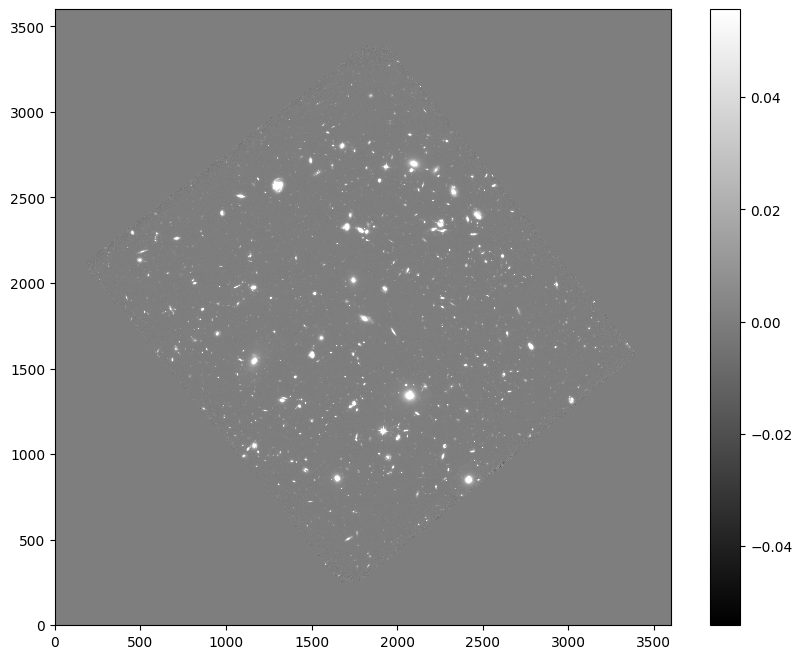

In [111]:
# shows the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("Hubble_1.png",bbox_inches='tight',dpi=400)

First we are getting the background of the image, then we are printing the mean and noise of the background. After that, we are making a 2d array that has the same size as the original image for the background. This is for back, which is the global mean. Finally, we are creating a graph to show the array. 

0.0
0.0005398219218477607


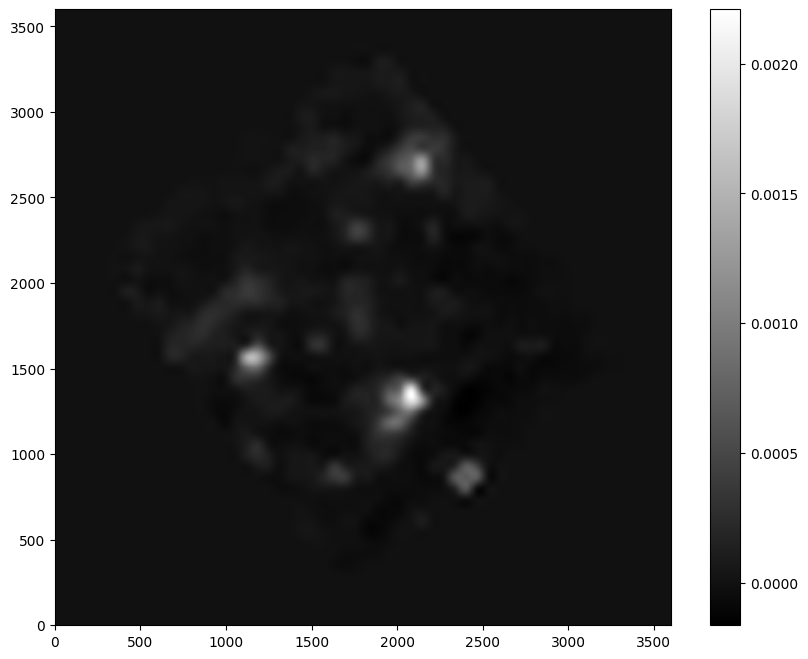

In [112]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("Hubble_2.png",bbox_inches='tight',dpi=400)

We are making a 2d array that has the same size as the original image for the background. This is for rms, which is the noise of the image background. We are also creating a graph to show the array. 

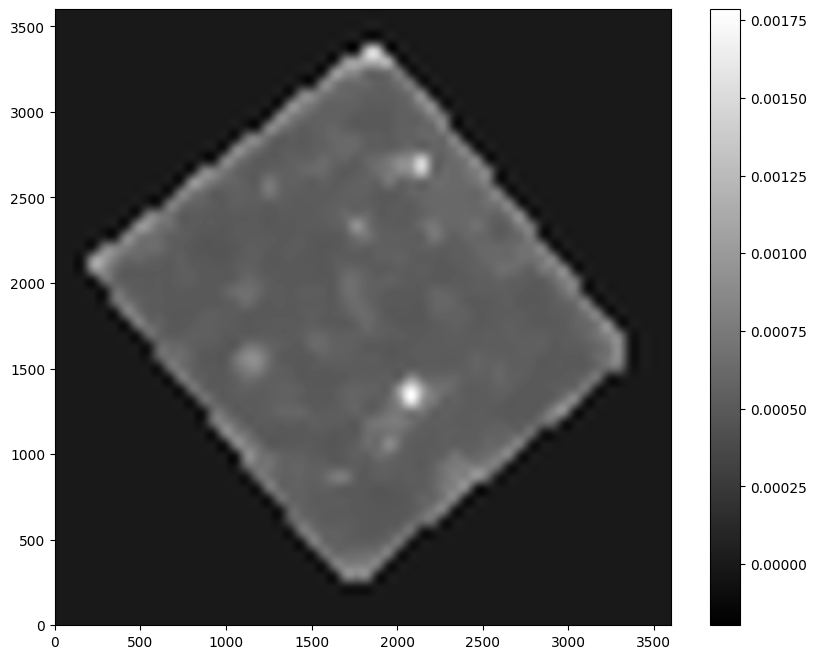

In [113]:

# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("Hubble_3.png",bbox_inches='tight',dpi=400)

We are removing the background of the image from data. We are also extracting and checking how many objects are in the image. There are 1360 objects or sources that were found.

In [114]:
# subtract the background
data_sub = data - bkg

objects = sep.extract(data_sub, 12, err=bkg.globalrms)

# how many objects were detected
len(objects)

1360

We are creating a plot that circles all the objects that are detected.

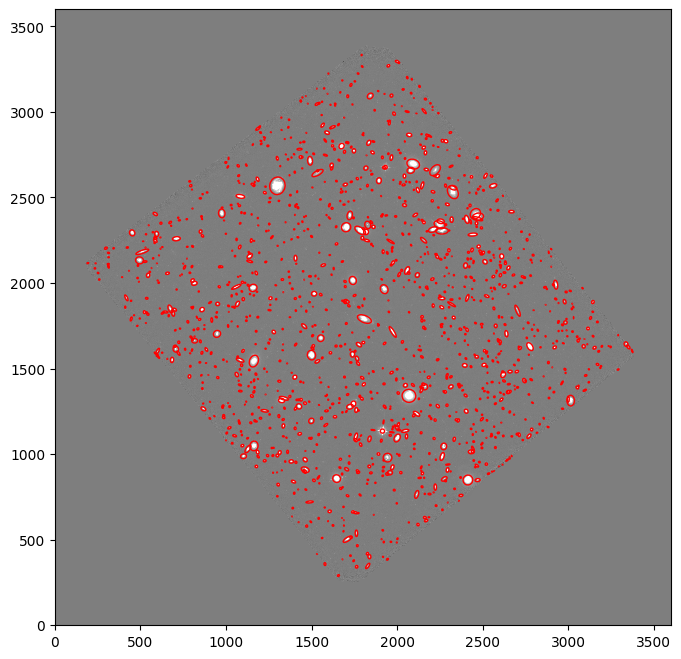

In [115]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("Hubble_4.png",bbox_inches='tight',dpi=400)

We are performing Aperture Photometry and using the flux to create a histogram.

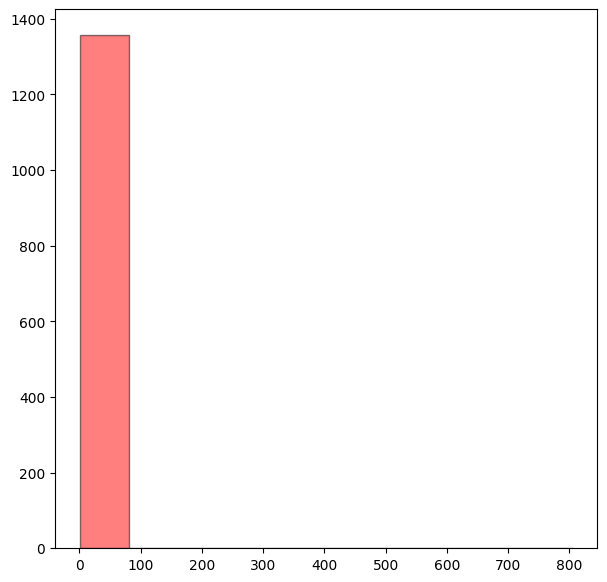

In [116]:
# available fields
objects.dtype.names
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
fs=11
lcolor='red'

f, ax = plt.subplots(1,1,figsize=(7,7))
ax.hist(flux,facecolor=lcolor,edgecolor='black',alpha=0.5)
plt.savefig("Historgram.png",bbox_inches='tight',dpi=400)

printing the flux of the first 10 objects

In [117]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1.151317 +/- 1.072998
object 1: flux = 0.553973 +/- 0.744299
object 2: flux = 1.117451 +/- 1.057100
object 3: flux = 0.876300 +/- 0.936113
object 4: flux = 0.288740 +/- 0.537353
object 5: flux = 0.152934 +/- 0.391079
object 6: flux = 0.698022 +/- 0.835482
object 7: flux = 0.214669 +/- 0.463333
object 8: flux = 0.497607 +/- 0.705418
object 9: flux = 0.743751 +/- 0.862415


The mean is 2.1395..., the std is 23.172..., the median is 0.37709... The largest outlier is 805.455 .... and it is 34.666... stds away from the mean. We can see where it is in the image in the graph below.

Finding the mean, std, median for flux. Then calculating zscore to find all the outliers. 

mean:2.139575075326727, std: 23.172422864163035, median:0.37709248982835575
list of outliers: [72.18374410629275, 805.4553882980348, 77.78802259922028, 214.1414422988892, 81.49096684217456]
largest outlier: 805.4553882980348
zscore of largest outlier: 34.66688908327597
238


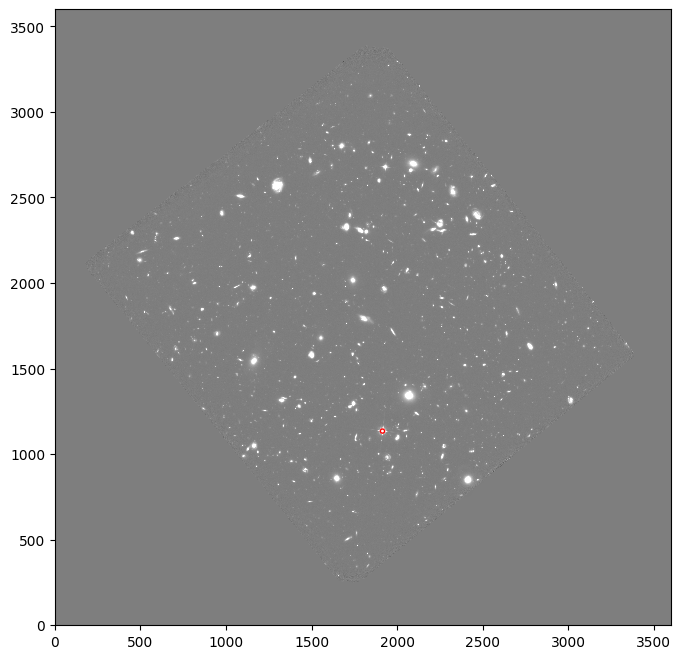

In [118]:
mean, std, median = np.mean(flux), np.std(flux), np.median(flux)
print(f"mean:{mean}, std: {std}, median:{median}")

r = 3
outliers = []
z_list = []
for x in flux:
    z = (x - mean) / std
    z_list.append(z)
    if abs(z) > r:
        outliers.append(x)
biggest_outlier = max(outliers)
biggest_zscore = max (z_list)
print(f"list of outliers: {outliers}")
print( f"largest outlier: {biggest_outlier}")
print (f"zscore of largest outlier: {biggest_zscore}")

v = 0
for x in range(len(objects)):
    if flux[x] == biggest_outlier:
        v = x
        print(x)

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object

e = Ellipse(xy=(objects['x'][v], objects['y'][v]),
            width=6*objects['a'][v],
            height=6*objects['b'][v],
            angle=objects['theta'][v] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)
plt.savefig("Outlier.png",bbox_inches='tight',dpi=400)